# BLU06 - Learning Notebook - Data wrangling workflows - Part 1 of 3

# Imports

In [1]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn')

import numpy as np
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris

# About the BLU 

## Data wrangling workflows

A typical data science workflow goes as follows: you get data from a source, you clean it, and then you continuously iterate on it.

![data_transformation_workflow](../media/data_processing_workflow.png)

On the previous learning units in this specialization, we focused mostly on getting and cleaning data (the blue boxes above). 

At this point, we got a dataset and performed necessary data cleaning. Our data is, therefore, in an interim state:
* You have a *tidy dataset* (observations as rows and features as columns), comprised of one or more tables
* You know how to import such tables into Pandas, regardless of the format they are stored.

Now, to explore, visualize and model the data, we have to perform transformations on it with agility, balancing:
* Speed of iteration, testing different hypothesis fast and easy
* Consistency, ensuring our pipeline doesn't collapse along the way.

In this first part, we'll go into how to transform the dataset and explore it in Pandas.

Then, we'll zoom in on a how to combine data frames.

Finally, we'll move to scikit-learn to build efficient pipelines for modeling.

# About the data

The New York Philharmonic played its first concert on December 7, 1842.

The data documents all known concerts, amounting to more than 20,000 performances. Some considerations:
* The Program is the top-most level element in the dataset
* A Program is defined as performances in which the repertoire, conductors, and soloists are the same
* A Program is associated with an Orchestra (e.g., New York Philharmonic) and a Season (e.g., 1842-43)
* A Program may have multiple Concerts with different dates, times and locations
* A Program's repertoire may contain various Works (e.g., two different symphonies by Beethoven)
* A Work can have multiple Soloists (e.g., Mahler on the harpsichord, Strauss or Bernstein on the piano).

**For more information about the dataset, including the data dictionary, please head to the README.**

In this unit, we will be using Works and Concerts, imported as follows.

In [2]:
works = pd.read_csv('../data/works.csv')
concerts = pd.read_csv('../data/concerts.csv')

# 1 Data transformation

## 1.1 Transformations as functions

Most data transformations operate on data frames: they receive a local data frame, transform it and return a new one.

In its simplest form, this is the signature of a generic data transformer.

In [3]:
def data_transformer(df):
    df = df.copy()
    # df = ...
    return df

Such transformations have no side effects and operate as functions on immutable data (i.e., they keep the original data frame unchanged).

Since the output depends only on the arguments, calling them with the same arguments always produces the same result.

Confusing? Not really.

In [4]:
def rename_column(df, new_name, old_name):
    df = df.copy()
    df[new_name] = df[old_name]
    df = df.drop(columns=old_name)
    return df

def test_dataframe():
    data = np.random.randn(6, 4)
    columns = ['A', 'B', 'C', 'D']
    return pd.DataFrame(data=data, columns=columns)

df = test_dataframe()

rename_column(df, 'Z', 'A')

,B,C,D,Z
0,-0.579783,-1.795174,-1.558540,0.569487
1,-1.336161,-0.107039,-0.338157,-0.378772
2,0.078547,-1.006981,0.902968,1.131927
3,-0.898132,1.925138,1.163364,0.977081
4,0.421911,-2.119159,0.502281,-0.497494
5,-0.365700,-0.253216,-0.025814,-0.113181


In [5]:
rename_column(df, 'Z', 'A')

,B,C,D,Z
0,-0.579783,-1.795174,-1.558540,0.569487
1,-1.336161,-0.107039,-0.338157,-0.378772
2,0.078547,-1.006981,0.902968,1.131927
3,-0.898132,1.925138,1.163364,0.977081
4,0.421911,-2.119159,0.502281,-0.497494
5,-0.365700,-0.253216,-0.025814,-0.113181


The same result, see! The program (or Notebook) remembers nothing but the original data and the function itself: a white canvas!

What about the original data frame?

In [6]:
df

,A,B,C,D
0,0.569487,-0.579783,-1.795174,-1.558540
1,-0.378772,-1.336161,-0.107039,-0.338157
2,1.131927,0.078547,-1.006981,0.902968
3,0.977081,-0.898132,1.925138,1.163364
4,-0.497494,0.421911,-2.119159,0.502281
5,-0.113181,-0.365700,-0.253216,-0.025814


After each call, the program *state* is the same as it was before (no new objects, no changes, no nothing!), as if nothing happened.

This property is valid for as long as we don't explicitly overwrite the original data frame outside the function, using an assignment.

In [7]:
df = test_dataframe()
df = rename_column(df, 'Z', 'A')

try:
    rename_column(df, 'Z', 'A')
except:
    print("For some reason this doesn't work. Why is that?")

For some reason this doesn't work. Why is that?


Mutable data is dangerous because it makes programs unpredictable. And this is why you should avoid modifying objects after creation.

Such pitfall is common in Notebooks, especially when you re-run cells, run them in a different order or restart the Kernel. (Am I right?)

**Data transformation is a *pipeline***

Another problem is that data transformation is about applying multiple, sequential changes to the data (i.e., a multistep process).

![data_transformation_pipeline](../media/data_transformation_pipeline.png)

*Fig 2. - A data transformation pipeline is a multistep process.*

And once we realize this, how do we go about it?

In [8]:
df = test_dataframe()

df_renamed = rename_column(df, 'Z', 'A')
# Code happens. Ideas are tested, hours go by.
df_renamed_without_b = df_renamed.drop(columns='B')
# More code happens. We keep on testing ideas, days go by.
df_renamed_without_b_positive = df_renamed_without_b[df_renamed_without_b > 0]
# There's a lot of code. Ideas come and go, we've been doing this for a week.
df_renamed_without_b_positive_no_nans = df_renamed_without_b_positive.dropna(how='all')
# Can we honestly trace back how to get from df to here? Probably not.
df_renamed_without_b_positive_no_nans

,C,D,Z
0,NaN,NaN,2.296835
1,0.360137,NaN,0.771893
2,0.335738,1.081975,0.337276
3,1.341901,1.713904,NaN
4,0.075541,0.907213,1.192374


Using functions instead, you concisely encapsulate everything. 

(Also, you spend less time naming things, unless you want to.)

In [9]:
def data_transformer(df, how_to_dropna):
    df = df.copy()
    df = rename_column(df, 'Z', 'A')
    df = df.drop(columns='B')
    df = df[df > 0]
    df = df.dropna(how=how_to_dropna)
    return df

data_transformer(df, how_to_dropna='all')

,C,D,Z
0,NaN,NaN,2.296835
1,0.360137,NaN,0.771893
2,0.335738,1.081975,0.337276
3,1.341901,1.713904,NaN
4,0.075541,0.907213,1.192374


This function is a bad one: names are not explicit, and there are no apparent blocks of logic.

Functions should organize and document our codebase (*what* you are doing and how).

Using functions, immutable data and avoiding side effects is a smart choice to manage complexity and keep things understandable.

Alternatively, we could structure our functions more like this.

In [10]:
def preprocess_data():
    df = df.copy()
    # df = rename_misspelled_columns(df)
    # df = drop_unnecessary_columns(df)
    # df = keep_only_positive_values(df)
    # df = removemissing_values(df)
    return df

## 1.2 Data transformation in Pandas

Pandas provides convenient methods for most data transformation tasks, with a unified, well-known syntax and consistent interfaces.

For example, we don't need to create a `rename_column()` function, since Pandas already provides a `df.rename()` method for us.

In [11]:
df = test_dataframe()

df.rename({'A': 'Z'}, axis=1)

,Z,B,C,D
0,0.378562,1.459458,-0.110582,-0.418155
1,-1.298560,-1.084775,-0.388366,0.973511
2,0.672452,-0.358207,-0.606391,2.400269
3,-0.464081,0.427514,0.938070,0.279481
4,-0.716379,1.128818,-0.042255,0.072923
5,0.402507,-1.439137,0.206846,-0.615740


As a recap: `df.rename()` follows our transformer signature:
* It takes a data frame as input 
* And returns a new one as output.

This predictable input/output is what we mean by consistent interfaces! 

It seems very promising to build and multistep pipelines, no? What transformations can we perform this way?

### 1.2.1 Subsetting columns or the index

#### Take a subset of indexes or columns

Pandas implements this functionality, somewhat counterintuitively, as `df.filter()`.

Imagine that we want only the columns related to the work itself, excluding IDs.

In [12]:
work_related_columns = ['ComposerName', 'WorkTitle', 'Movement']
# Select columns by name.
works.filter(items=work_related_columns).head()

,ComposerName,WorkTitle,Movement
0,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN
1,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN
2,"Beethoven, Ludwig van","EGMONT, OP.84",Overture
3,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN
4,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN


We can also use it to subset our data frame based on the index.

In [13]:
# Select rows containing 'Glass' on the index.
works.set_index('ComposerName').filter(like='Glass', axis=0).reset_index().head()

,ComposerName,GUID,ProgramID,WorkID,MovementID,WorkTitle,Movement,ConductorName,Interval
0,"Glass, Philip",cf230066-2cd2-4093-8b78-b91b8dda3cbf,11639,5729,NaN,KOYAANISQATSI,NaN,"Riesman, Michael",NaN
1,"Glass, Philip",adf68bf5-db9d-4b24-aac6-c9b7c398cf06,14047,12401,NaN,"""FATHER DEATH BLUES"" FROM HYDROGEN JUKEBOX",NaN,"Sainte-Agathe, Valérie",NaN
2,"Glass, Philip",990a8f66-cd5f-466e-b3b6-800baa6c0b47-0.1,14189,12547,NaN,"QUARTET, STRING, NO. 3 (MISHIMA)",NaN,NaN,NaN
3,"Glass, Philip",3d50968c-2e8b-405f-969c-ba36f941f393,14189,12547,NaN,"QUARTET, STRING, NO. 3 (MISHIMA)",NaN,NaN,NaN
4,"Glass, Philip",fb8e7125-7ef9-492e-a820-914467475701,14025,12327,NaN,SARABANDE IN COMMON TIME (SOLO VIOLIN),NaN,NaN,NaN


#### Drop columns

Additionally, `GUID` and `ProgramID` are pretty redundant. We can get rid of `ProgramID`.

In [14]:
works.drop(columns='ProgramID').head()

,GUID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN


### 1.2.2 Subsetting rows

Listed among works with a distinct interval tag are intermissions (i.e., the intervals). Let's get rid of them!

As we've learned, we can use `df.loc`.

In [15]:
def subset(df, mask):
    return df.loc[mask, :]

mask = works['Interval'].isnull()
subset(works, mask).head()

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN


### 1.2.4 Sort (rearrange rows)

Sometimes we want to rearrange rows in a particular way. The simplest form is to use `df.sort_index()`.

In [16]:
works.set_index('ComposerName').sort_index().head()

,GUID,ProgramID,WorkID,MovementID,WorkTitle,Movement,ConductorName,Interval
ComposerName,,,,,,,,
"ACT,",83a9db5d-dcf2-40c0-87f9-80e78775c655,10632,6219,1.0,NaN,NaN,"Thomas, Michael Tilson",NaN
"ACT,",83a9db5d-dcf2-40c0-87f9-80e78775c655,10632,6219,2.0,NaN,NaN,"Thomas, Michael Tilson",NaN
"Abert, Johann Joseph",09f72cc8-441f-45e1-a3ab-00761bcae65f,5687,1995,NaN,CHORALE,NaN,"Schelling, Ernest",NaN
"Abt, Franz",a9b31227-e23a-4946-bdb9-08e079aeb3d5,2574,4126,NaN,"POLISH MOTHER'S CRADLE SONG, THE",NaN,"Eisfeld, Theodore",NaN
"Abt, Franz",8664acc7-eb8b-40a2-95ad-8af85d139cd6,10569,10761,NaN,MY FATHERLAND,NaN,"Damrosch, Frank",NaN


Or, alternatively, we can use `df.sort_values()`.

In [17]:
works.sort_values('ComposerName').head()

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
13030,83a9db5d-dcf2-40c0-87f9-80e78775c655,10632,6219,1.0,"ACT,",NaN,NaN,"Thomas, Michael Tilson",NaN
80136,83a9db5d-dcf2-40c0-87f9-80e78775c655,10632,6219,2.0,"ACT,",NaN,NaN,"Thomas, Michael Tilson",NaN
54610,09f72cc8-441f-45e1-a3ab-00761bcae65f,5687,1995,NaN,"Abert, Johann Joseph",CHORALE,NaN,"Schelling, Ernest",NaN
66689,a9b31227-e23a-4946-bdb9-08e079aeb3d5,2574,4126,NaN,"Abt, Franz","POLISH MOTHER'S CRADLE SONG, THE",NaN,"Eisfeld, Theodore",NaN
14346,8664acc7-eb8b-40a2-95ad-8af85d139cd6,10569,10761,NaN,"Abt, Franz",MY FATHERLAND,NaN,"Damrosch, Frank",NaN


If for some reason we are feeling conservative and want more control,  we use `df.loc` to pass an array of indexes.

In [18]:
rearranged_index = np.random.permutation(works.index)[:5]
rearranged_index

array([26196, 47276, 75229, 51509, 36956])

In [19]:
works.loc[rearranged_index, :]

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
26196,57972193-17d8-4b73-b1fb-2fcabea0cc2d,10010,51569,NaN,"Rachmaninoff, Sergei","RHAPSODY ON A THEME OF PAGANINI, OP. 43",NaN,"Tovey, Bramwell",NaN
47276,175c401a-fd85-4a2f-8c2c-7d4acd2073a5,6942,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Bernstein, Leonard",NaN
75229,cd5d411e-2b4d-426e-88af-602d9796ccec,11789,5129,6.0,"Rodgers, Richard",SOUTH PACIFIC: SYMPHONIC SCENARIO (ARR. Bennett),Happy Talk,"Tovey, Bramwell",NaN
51509,e5cfbddf-a9ee-4aad-a79a-dcc3d5f86f8a,11637,1606,2.0,"North, Alex",SPARTACUS,Forest Meeting/Love Theme,"Williams, John",NaN
36956,f5d93e14-8fc9-45b5-9e1c-e5564f128412,6575,52076,NaN,"Haydn, Franz Joseph","SYMPHONY NO. 88, G MAJOR",NaN,"DePreist, James",NaN


### 1.2.5 Add new columns or change the existing ones (with a twist)

What do you do when you want to create or change an existing column?

In [20]:
works_ = works.copy()
works_['ComposerLastName'] = works['ComposerName'].str.split(',').str.get(0)
works_.head()

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval,ComposerLastName
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN,Beethoven
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN,Beethoven
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN,Beethoven
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN,Beethoven
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN,Beethoven


We created a new copy of the data frame and added the new column, to keep data immutable and avoid complexity.

Nonetheless, intermediate steps give you more control (sort of) but make our overall flow less, well, *fluent*. 

Like a dam, if you will.

What if there was a functional transformation that you could use instead? (There is!)

In [21]:
works.assign(ComposerLastName=works['ComposerName'].str.split(',').str.get(0)).head()

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval,ComposerLastName
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN,Beethoven
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN,Beethoven
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN,Beethoven
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN,Beethoven
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN,Beethoven


The method `df.assign()` assigns new columns to the data frame, returning all the original columns, plus the new one.

And you can use it to change existing columns as well. Let's fix the uppercase conundrum in the `WorkTitle`.

In [22]:
works.assign(WorkTitle=works['WorkTitle'].str.title()).head()

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","Symphony No. 5 In C Minor, Op.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","Symphony No. 3 In E Flat Major, Op. 55 (Eroica)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","Egmont, Op.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","Symphony No. 2 In D Major, Op.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","Symphony No. 7 In A Major, Op.92",NaN,"Hill, Ureli Corelli",NaN


Solved. Convenient!

### 1.2.6 Rename rows or columns (with a twist)

What's the most common way to rename columns in Pandas? We check the existing names.

In [23]:
works.columns

Index(['GUID', 'ProgramID', 'WorkID', 'MovementID', 'ComposerName',
       'WorkTitle', 'Movement', 'ConductorName', 'Interval'],
      dtype='object')

Hopefully, we create a copy of the data frame. 

In [24]:
works_ = works.copy()

Please note we create a new object to overwrite our previous `works_` data frame. 

Where's the variable `ComposerLastName` now? Nowhere to be seen, because we just reassigned `works_`.

In [25]:
# Uncomment to see the error.
# works_['ComposerLastName']

Duck tape. Duck tape everywhere.

Back to our quest, renaming columns. This implementation is standard.

In [26]:
works_.columns = works.columns.str.upper()
works_.head()

,GUID,PROGRAMID,WORKID,MOVEMENTID,COMPOSERNAME,WORKTITLE,MOVEMENT,CONDUCTORNAME,INTERVAL
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN


What if we could express this functionally? 

(At this point, you are already kind of expecting that we can.)

In [27]:
works.rename(str.upper, axis=1).head()

,GUID,PROGRAMID,WORKID,MOVEMENTID,COMPOSERNAME,WORKTITLE,MOVEMENT,CONDUCTORNAME,INTERVAL
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN


What about that? Isn't it cool? You can also rename specific columns using a dictionary.

In [28]:
works.rename({'GUID': 'ID'}, axis=1).head()

,ID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN


### 1.2.7 Split-aply-combine

A refresher on split-apply-combine:
* You split data into groups
* You apply a function to each group, independently
* You combine the results into a single data frame.

With this out of the way, it's time to focus on three types of functions you may want to apply:
* Aggregation (e.g., sum, count, mean)
* Transformation (e.g., filling missing values)
* Filtration (e.g., discard data from underrepresented groups).

We will drill-down into each one of them. For this next part, we will use be using the `concerts` data.

**Aggregation**

We want to start by uncovering the most popular programs, by the number of performances.

Please note that no splitting occurs until needed, it only verifies that we’ve passed a valid mapping.

In [29]:
concerts.groupby('ProgramID').size().nlargest()

ProgramID
3128     16
3139     16
10700    16
10702    16
3134     12
dtype: int64

We use `GroupBy.size()` to count the number of elements in each group. A list of available methods:
* `mean()`
* `sum()`
* `size()`
* `count()`
* `std()`
* `var()`
* `sem()`
* `describe()`
* `first()`
* `last()`
* `nth()`
* `min()`
* `max()`.

Alternatively, we can use `GroupBy.agg()` as a more general method. For a refresher, check out the [docs](http://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html).

**Transformation**

The inherent difference between aggregation and transformation is that the later returns an object the same size as the original input.

We don't have an excellent example in our dataset, so let's use the [Iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset to exemplify a possible use case.

In [30]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df = df.assign(Target=iris.target)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Now, imagine that we want to standardize the data, but using the statistics for each group:
* We take the mean and the standard deviation *inside each group*
* We want to standardize each value according to that.

We implement it as a lambda function, that will be applied to each group separately.

In [31]:
zscore = lambda x: (x - x.mean()) / x.std()

df.groupby('Target').transform(zscore).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.266674,0.215209,-0.368852,-0.410411
1,-0.300718,-1.097043,-0.368852,-0.410411
2,-0.868111,-0.572142,-0.945184,-0.410411
3,-1.151807,-0.834592,0.207479,-0.410411
4,-0.017022,0.477660,-0.368852,-0.410411


The downside is that, since we are returning the entire data frame, it can't return `Target` as the index, so we lose the column.

Let's make sure we got this right.

In [32]:
df_transformed = df.groupby('Target').transform(zscore)

df_transformed.groupby(df['Target']).agg(['mean', 'std'])

sepal length (cm)      sepal width (cm)      petal length (cm)       \
                    mean  std             mean  std              mean  std   
Target                                                                       
0          -6.739748e-16  1.0    -4.318768e-16  1.0      1.099121e-16  1.0   
1           4.996004e-17  1.0    -1.486589e-15  1.0      4.352074e-16  1.0   
2           2.757794e-15  1.0    -6.800116e-16  1.0     -1.010303e-15  1.0   

       petal width (cm)       
                   mean  std  
Target                        
0          1.443290e-16  1.0  
1          8.165690e-16  1.0  
2         -9.459100e-16  1.0

We did it! Zero mean and standard deviation equal to one *inside each group*.

Now, if this use case doesn't ring a bell, think about replacing missing values with the group mean, for example. Useful, right?

**Filtration**

The method `DataFrameGroupBy.filter()` provides a convenient way to filter out elements that belong to underrepresented groups.

In [33]:
concerts.groupby('ProgramID').filter(lambda x: x.shape[0] > 15).head()

,GUID,ProgramID,ConcertID,EventType,Location,Venue,Date,Time
6608,8ad0bfa4-09b9-4b18-889b-d0c426410cbb,3128,0,Special,"Manhattan, NY",Roxy Theatre,1950-09-01T04:00:00+00:00,12:00PM
6610,1e1114aa-7152-4305-a357-7aac149b8599,3139,0,Special,"Manhattan, NY",Roxy Theatre,1950-09-08T04:00:00+00:00,NaN
6689,b37d1833-3252-41a6-9f3e-fbd596b215b0,10700,0,Special,"Manhattan, NY",Roxy Theatre,1951-05-09T04:00:00+00:00,12:40PM
6691,35fda061-f4c4-423c-a8ab-feb792caee34,10702,0,Special,"Manhattan, NY",Roxy Theatre,1951-05-16T04:00:00+00:00,NaN
15517,8ad0bfa4-09b9-4b18-889b-d0c426410cbb,3128,1,Special,"Manhattan, NY",Roxy Theatre,1950-09-01T04:00:00+00:00,NaN


It returns a subset of the original data frame, depending on a function applied to the group as a whole.

### 1.2.8 Method chaining

Now we know about some of the most common individual transformations we can use. But how can we combine them?

Data transformation is a pipeline, i.e., some sequential transformations, *chained* together.

This chaining means that each transformation returns an object that will be consumed by the next one, and so on, in a pre-defined order.

As we've seen, a familiar syntax is to declare intermediate variables for each output, used as input to the next function.

In [34]:
mask = works['Interval'].isnull()
df_no_intervals = subset(works, mask)

df_exclude_minor_composers = df_no_intervals.groupby('ComposerName').filter(lambda x: x.shape[0] > 10)

df_work_related = df_exclude_minor_composers.filter(items=work_related_columns)
df_work_related_no_movement = df_work_related.drop(columns='Movement')
df_work_related_no_movement_unique = df_work_related_no_movement.drop_duplicates()

works_per_composer = df_work_related_no_movement_unique.groupby('ComposerName').size()
works_per_composer_sorted = works_per_composer.nlargest()
works_per_composer_sorted

ComposerName
Traditional,                  640
Bach,  Johann  Sebastian      306
Mozart,  Wolfgang  Amadeus    242
Schubert,  Franz              158
Beethoven,  Ludwig  van       144
dtype: int64

These declarations are syntactic sugar: they make it easier to read and express confusing things such as data pipelines. Some downsides:
* We need to create an extra variable per intermediate step
* Cognitive burden of naming each variable and keeping them in mind
* They make the code less fluid
* They make it harder to visualize the whole picture of what your program (or Notebook) is doing
* They are error-prone and heavily reliant on the state, which is dangerous as we've seen.

What if there was an alternative?

Method chaining allows invoking multiple method calls chained together in a single statement, each receiving and returning an object.

This syntax has always been possible with Pandas, but more and more methods and being added that (try to guess it!):
* Receive a data frame
* Return a transformed data frame.

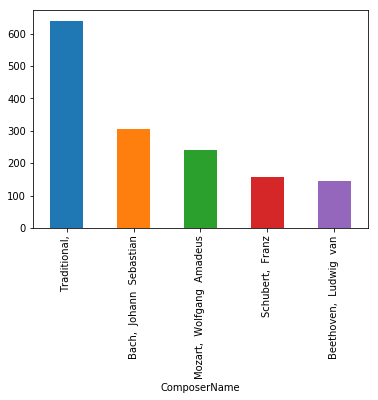

In [35]:
no_intervals = works['Interval'].isnull()
df_no_intervals = subset(works, no_intervals)

df_work_related = df_no_intervals.filter(items=work_related_columns)

(df_work_related.groupby('ComposerName').filter(lambda x: x.shape[0] > 10)
                .drop(columns='Movement')
                .drop_duplicates()
                .groupby('ComposerName').size()
                .nlargest()
                .plot(kind='bar'));

Code flows from top to bottom, and the function parameters are always near the function. 

Also, you eliminate an extra variable for each intermediate steps.

Now, explicitly naming things is good. Ideally, you want to chain functions that make sense together and encapsulate them in logically.

In [36]:
def get_top_5_composers(df):
    df = df.copy()
    
    no_intervals = df['Interval'].isnull()
    df = subset(df, no_intervals)
    
    work_related_columns = ['ComposerName', 'WorkTitle', 'Movement']
    
    df = (df.filter(work_related_columns)
            .groupby('ComposerName').filter(lambda x: x.shape[0] > 10)
            .drop(columns='Movement')
            .drop_duplicates()
            .groupby('ComposerName').size()
            .nlargest())
    return df

top_5_composers = get_top_5_composers(works)
top_5_composers

ComposerName
Traditional,                  640
Bach,  Johann  Sebastian      306
Mozart,  Wolfgang  Amadeus    242
Schubert,  Franz              158
Beethoven,  Ludwig  van       144
dtype: int64

Another drawback to excessively long chains is that debugging is harder, as there no intermediate values to inspect.

**Segregate your code as to avoid long chains and keep only together what belongs together.**

(In case of doubt, read [The Zen of Python](https://www.python.org/dev/peps/pep-0020/) out loud ten times.)

### 1.2.9 Custom methods and pipes

Now, for the final trick.

The function `subset()` has the exact signature we want, again:
* It receives a data frame
* It return a transformed data frame.

What if Pandas had a way to include such functions in pipelines? Meet `df.pipe()`!

The method `df.pipe()` allows us to include user-defined functions in method chains (aka pipelines).

It works like this.

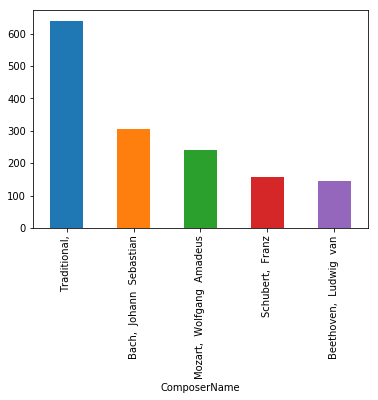

In [37]:
(df_work_related.pipe(subset, no_intervals)
                .filter(items=work_related_columns)
                .groupby('ComposerName').filter(lambda x: x.shape[0] > 10)
                .drop(columns='Movement')
                .drop_duplicates()
                .groupby('ComposerName').size()
                .nlargest()
                .plot(kind='bar'));

So, this should work.

In [38]:
def get_top_5_composers(df):
    no_intervals = df['Interval'].isnull()
    work_related_columns = ['ComposerName', 'WorkTitle', 'Movement']
    
    df = df.copy()
    df = (df.pipe(subset, no_intervals)
            .filter(items=work_related_columns)
            .groupby('ComposerName').filter(lambda x: x.shape[0] > 10)
            .drop(columns='Movement')
            .drop_duplicates()
            .groupby('ComposerName').size()
            .nlargest())
    
    return df

top_5_composers = get_top_5_composers(works)
top_5_composers

ComposerName
Traditional,                  640
Bach,  Johann  Sebastian      306
Mozart,  Wolfgang  Amadeus    242
Schubert,  Franz              158
Beethoven,  Ludwig  van       144
dtype: int64

And it does!

Now, we have all the tools we need to build robust data transformation pipelines in Pandas.

In the next Notebook, you will learn how to combine data frames.